# **LAB 02: LÀM VIỆC VÀ TRỰC QUAN HÓA DỮ LIỆU CHUỖI THỜI GIAN**

#### Môn học: Trực quan hóa dữ liệu

#### Nhóm: 5


## **A. Thu thập dữ liệu**




nhóm 5 lựa chọn bộ dữ liệu *U.S. Air Pollution* cho lab 01. Bộ dữ liệu được chia sẻ miễn phí trên nền tảng data.world. (Link dataset: https://data.world/data-society/us-air-pollution-data)

License: <a href="http://opendatacommons.org/licenses/dbcl/1.0/">Database: Open Database, Contents: Database Contents</a>


Bộ dữ liệu được thu thập bằng cách scraped từ database của trang U.S. EPA : https://aqsdr1.epa.gov/aqsweb/aqstmp/airdata/download_files.html


## **B. Khám phá dữ liệu**

### **Import các thư viện**

In [4]:
!pip install pingouin
!pip install category_encoders
!pip install plotly
!pip install yellowbrick
!pip install numpy==1.21
!pip install holoviews
!pip install datashader

     -------------------------------------- 198.6/198.6 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7028 sha256=0a62784a37b89b4dda29589de1234713a8f3f1ced70966aa3957892cb32e651c
  Stored in directory: c:\users\vinhp\appdata\local\pip\cache\wheels\04\bb\0d\2d02ec45f29c48d6192476bfb59c5a0e64b605e7212374dd15
Successfully built littleutils


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from ipywidgets import widgets
from plotly.offline import  iplot

from statsmodels.tsa.seasonal import seasonal_decompose
from plotly.subplots import make_subplots


#!pip install holoviews
#!pip install datashader
import datashader as ds
import holoviews as hv

from holoviews import opts
from holoviews.operation.datashader import datashade, shade, dynspread, spread
from holoviews.operation.datashader import rasterize, ResamplingOperation
from holoviews.operation import decimate



from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

%matplotlib inline  

### **Đọc file dữ liệu vào dataframe**

In [7]:
df=pd.read_csv("pollution_us_2000_2016.csv")
df.head()


,Unnamed: 0,State Code,County Code,Site Num,Address,State,County,City,Date Local,NO2 Units,...,SO2 Units,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,CO Units,CO Mean,CO 1st Max Value,CO 1st Max Hour,CO AQI
0,0,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,...,Parts per billion,3.000000,9.0,21,13.0,Parts per million,1.145833,4.2,21,NaN
1,1,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,...,Parts per billion,3.000000,9.0,21,13.0,Parts per million,0.878947,2.2,23,25.0
2,2,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,...,Parts per billion,2.975000,6.6,23,NaN,Parts per million,1.145833,4.2,21,NaN
3,3,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,...,Parts per billion,2.975000,6.6,23,NaN,Parts per million,0.878947,2.2,23,25.0
4,4,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-02,Parts per billion,...,Parts per billion,1.958333,3.0,22,4.0,Parts per million,0.850000,1.6,23,NaN


### **Tiền xử lý và khám phá dữ liệu**

Đầu tiên ta sẽ xóa dòng index của dataset.

In [8]:
df=df.drop(columns="Unnamed: 0")

**Số dòng** và **số cột** của bộ dữ liệu:

In [9]:
num_rows, num_cols = df.shape
print("Num rows: ", num_rows)
print("Num cols: ", num_cols)

Num rows:  1746661
Num cols:  28


**Ý nghĩa của mỗi dòng**: Thông tin về nồng độ NO2, O3, SO2, CO trong không khí ở một thành phố trong một ngày.

In [10]:
pd.set_option('display.max_columns', None)
df.head(1)

,State Code,County Code,Site Num,Address,State,County,City,Date Local,NO2 Units,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI,O3 Units,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,SO2 Units,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,CO Units,CO Mean,CO 1st Max Value,CO 1st Max Hour,CO AQI
0,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,19.041667,49.0,19,46,Parts per million,0.0225,0.04,10,34,Parts per billion,3.0,9.0,21,13.0,Parts per million,1.145833,4.2,21,NaN


Kiểm tra xem có dòng nào bị trùng lặp hay không:

In [11]:
df.duplicated().sum()

5032

Thực hiện loại bỏ các dòng trùng lặp:

In [12]:
df=df.drop_duplicates()

In [13]:
df.head()

,State Code,County Code,Site Num,Address,State,County,City,Date Local,NO2 Units,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI,O3 Units,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,SO2 Units,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,CO Units,CO Mean,CO 1st Max Value,CO 1st Max Hour,CO AQI
0,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,19.041667,49.0,19,46,Parts per million,0.022500,0.040,10,34,Parts per billion,3.000000,9.0,21,13.0,Parts per million,1.145833,4.2,21,NaN
1,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,19.041667,49.0,19,46,Parts per million,0.022500,0.040,10,34,Parts per billion,3.000000,9.0,21,13.0,Parts per million,0.878947,2.2,23,25.0
2,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,19.041667,49.0,19,46,Parts per million,0.022500,0.040,10,34,Parts per billion,2.975000,6.6,23,NaN,Parts per million,1.145833,4.2,21,NaN
3,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,19.041667,49.0,19,46,Parts per million,0.022500,0.040,10,34,Parts per billion,2.975000,6.6,23,NaN,Parts per million,0.878947,2.2,23,25.0
4,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-02,Parts per billion,22.958333,36.0,19,34,Parts per million,0.013375,0.032,10,27,Parts per billion,1.958333,3.0,22,4.0,Parts per million,0.850000,1.6,23,NaN


**Ý nghĩa của mỗi cột**: 

- `State Code` : Mã tiểu bang.
- `County code` : Mã quận.
- `Site Num` : Số site ở mỗi quận.
- `Address`: Địa chỉ
- `State` : Tên tiểu bang.
- `County` : Tên quận
- `City` : Tên thành phố
- `Date Local` : Ngày thực hiện đo.


4 chất gây ô nhiễm không khí ($NO_2, O_3, SO_2$ và  $O_3$), ứng với mỗi chất có 5 cột giá trị. Ví dụ đối với $NO_2$:

- `NO2 Units` : đơn vị đo lường NO2
- `NO2 Mean` : trung bình nồng độ NO2 trong một ngày cụ thể.
- `NO2 AQI` : chỉ số chất lượng không khí được tính toán bởi NO2 trong một ngày cụ thể.
-   `NO2 1st Max Value` : Giá trị lớn nhất của nồng độ NO2 trong ngày.
- `NO2 1st Max Hour` : Thời gian mà nồng độ NO2 đạt giá trị lớn nhất.

Ta sẽ thực hiện chuẩn hóa tên các cột để thuận tiện hơn cho việc sử dụng về sau:

In [14]:
df.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)

**Kiểu dữ liệu của mỗi cột:**

In [15]:
df.dtypes

State_Code             int64
County_Code            int64
Site_Num               int64
Address               object
State                 object
County                object
City                  object
Date_Local            object
NO2_Units             object
NO2_Mean             float64
NO2_1st_Max_Value    float64
NO2_1st_Max_Hour       int64
NO2_AQI                int64
O3_Units              object
O3_Mean              float64
O3_1st_Max_Value     float64
O3_1st_Max_Hour        int64
O3_AQI                 int64
SO2_Units             object
SO2_Mean             float64
SO2_1st_Max_Value    float64
SO2_1st_Max_Hour       int64
SO2_AQI              float64
CO_Units              object
CO_Mean              float64
CO_1st_Max_Value     float64
CO_1st_Max_Hour        int64
CO_AQI               float64
dtype: object

Cột `Date_Local` chưa có kiểu dữ liệu phù hợp, ta sẽ thực hiện chuyển kiểu dữ liệu về kiểm **datetime**

In [16]:
df['Date_Local'] = pd.to_datetime(df['Date_Local'], format='%Y-%m-%d')

Chuyển các cột `State_Code`, `County_Code` sang **string**

In [17]:
df[['State_Code', 'County_Code','Site_Num']]=df[['State_Code', 'County_Code','Site_Num']].astype(str)

**Kiểm tra giá trị bị thiếu:**

In [18]:
df.isna().sum()/df.shape[0]

State_Code           0.00000
County_Code          0.00000
Site_Num             0.00000
Address              0.00000
State                0.00000
County               0.00000
City                 0.00000
Date_Local           0.00000
NO2_Units            0.00000
NO2_Mean             0.00000
NO2_1st_Max_Value    0.00000
NO2_1st_Max_Hour     0.00000
NO2_AQI              0.00000
O3_Units             0.00000
O3_Mean              0.00000
O3_1st_Max_Value     0.00000
O3_1st_Max_Hour      0.00000
O3_AQI               0.00000
SO2_Units            0.00000
SO2_Mean             0.00000
SO2_1st_Max_Value    0.00000
SO2_1st_Max_Hour     0.00000
SO2_AQI              0.49973
CO_Units             0.00000
CO_Mean              0.00000
CO_1st_Max_Value     0.00000
CO_1st_Max_Hour      0.00000
CO_AQI               0.50010
dtype: float64

Có gần 50% giá trị bị thiếu ở 2 cột `SO2_AQI` và `CO_AQI`, ta tìm cách để điền các giá trị bị thếu ở 2 cột này. Thử kiểm tra độ tương quan của 2 thuộc tính này với các thuộc khác:

In [19]:
df.corr()[["SO2_AQI","CO_AQI"]]

,SO2_AQI,CO_AQI
NO2_Mean,0.295155,0.661453
NO2_1st_Max_Value,0.277796,0.612002
NO2_1st_Max_Hour,0.020904,0.057343
NO2_AQI,0.281254,0.614904
O3_Mean,-0.071260,-0.356409
O3_1st_Max_Value,0.034398,-0.179837
O3_1st_Max_Hour,0.028698,0.006956
O3_AQI,0.051849,-0.130517
SO2_Mean,0.828281,0.203056
SO2_1st_Max_Value,0.987755,0.148843


`SO2_AQI` có quan hệ tuyến tính với `SO2_1st_Max_Value` (hệ số tương quan=0.987755) và `CO_AQI` có quan hệ tuyến tính với `CO_1st_Max_Value` ((hệ số tương quan=0.998375))

Text(0, 0.5, 'CO_AQI')

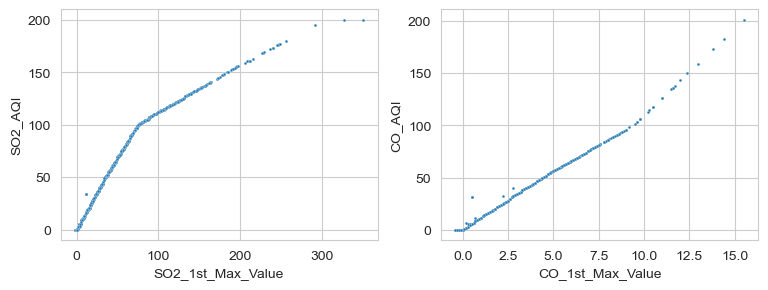

In [20]:
fig, axs = plt.subplots(ncols=2, figsize=(9,3))

sns.scatterplot(x=df["SO2_1st_Max_Value"], y=df["SO2_AQI"], ax=axs[0],s=3)
axs[0].set_xlabel("SO2_1st_Max_Value")
axs[0].set_ylabel("SO2_AQI")

sns.scatterplot(x=df["CO_1st_Max_Value"], y=df["CO_AQI"], ax=axs[1],s=3)
axs[1].set_xlabel("CO_1st_Max_Value")
axs[1].set_ylabel("CO_AQI")

Dữ liệu phân bố gần như trên một đường cong, ta sẽ xây dựng mô hình hồi quy bậc 2 để điền các giá trị thiếu trong `SO2_AQI` và `CO_AQI`:

In [21]:
existing_data_SO2 = df[df['SO2_AQI'].notna()]
poly = PolynomialFeatures(degree=2)
X = poly.fit_transform(existing_data_SO2['SO2_1st_Max_Value'].values.reshape(-1, 1))
y = existing_data_SO2['SO2_AQI'].values
model1 = LinearRegression()
model1.fit(X,y)
print(" R-squared score for SO2_AQI model: ",model1.score(X, y))

existing_data_CO = df[df['CO_AQI'].notna()]
poly = PolynomialFeatures(degree=2)
X = poly.fit_transform(existing_data_CO['CO_1st_Max_Value'].values.reshape(-1, 1))
y = existing_data_CO['CO_AQI'].values
model2 = LinearRegression()
model2.fit(X,y)

print(" R-squared score for CO_AQI model ",model2.score(X, y))

 R-squared score for SO2_AQI model:  0.9971336100583899
 R-squared score for CO_AQI model  0.9968621291603517


2 model cho kết tốt, thực hiện điền các giá trị thiếu:

In [22]:
df['SO2_AQI_pred'] = model1.predict(poly.fit_transform(df['SO2_1st_Max_Value'].values.reshape(-1, 1)))
df['SO2_AQI'] = np.where(df['SO2_AQI'].isnull(), df['SO2_AQI_pred'], df['SO2_AQI'])


df['CO_AQI_pred'] = model2.predict(poly.fit_transform(df['CO_1st_Max_Value'].values.reshape(-1, 1)))
df['CO_AQI'] = np.where(df['CO_AQI'].isnull(), df['CO_AQI_pred'], df['CO_AQI'])

df = df.drop(columns=['SO2_AQI_pred','CO_AQI_pred'])

**Phân bố giá trị của các cột numerical:**

Bảng thống kê cơ bản về các phân bố giá trị của các thuộc tính **numeric**:

In [23]:
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()


In [24]:
df[numeric_cols].describe().round(2)

,NO2_Mean,NO2_1st_Max_Value,NO2_1st_Max_Hour,NO2_AQI,O3_Mean,O3_1st_Max_Value,O3_1st_Max_Hour,O3_AQI,SO2_Mean,SO2_1st_Max_Value,SO2_1st_Max_Hour,SO2_AQI,CO_Mean,CO_1st_Max_Value,CO_1st_Max_Hour,CO_AQI
count,1741629.00,1741629.00,1741629.00,1741629.00,1741629.00,1741629.00,1741629.00,1741629.00,1741629.00,1741629.00,1741629.00,1741629.00,1741629.00,1741629.00,1741629.00,1741629.00
mean,12.82,25.41,11.73,23.89,0.03,0.04,10.17,36.04,1.87,4.50,9.66,6.06,0.37,0.62,7.87,7.04
std,9.51,16.00,7.88,15.16,0.01,0.02,4.00,19.74,2.76,7.69,6.73,10.42,0.31,0.64,7.98,7.34
min,-2.00,-2.00,0.00,0.00,0.00,0.00,0.00,0.00,-2.00,-2.00,0.00,-3.20,-0.44,-0.40,0.00,-3.60
25%,5.75,13.00,5.00,12.00,0.02,0.03,9.00,25.00,0.26,0.90,5.00,0.65,0.18,0.29,0.00,3.00
50%,10.74,24.00,9.00,23.00,0.03,0.04,10.00,33.00,0.99,2.00,8.00,2.94,0.29,0.40,6.00,5.00
75%,17.71,35.60,20.00,33.00,0.03,0.05,11.00,42.00,2.33,5.00,14.00,7.00,0.47,0.80,13.00,9.00
max,139.54,267.00,23.00,132.00,0.10,0.14,23.00,218.00,321.62,351.00,23.00,200.00,7.51,19.90,23.00,210.01


**Phân bố giá trị của các cột categorical:**

In [25]:
df[set(df.columns)-set(numeric_cols)].describe()

,CO_Units,County,Site_Num,SO2_Units,NO2_Units,State_Code,County_Code,O3_Units,State,Date_Local,Address,City
count,1741629,1741629,1741629,1741629,1741629,1741629,1741629,1741629,1741629,1741629,1741629,1741629
unique,1,133,110,1,1,47,73,1,47,5996,204,144
top,Parts per million,Los Angeles,5,Parts per billion,Parts per billion,6,13,Parts per million,California,2013-04-17 00:00:00,PIKE AVE AT RIVER ROAD,Not in a city
freq,1741629,93371,76108,1741629,1741629,575628,149178,1741629,575628,408,35117,138375
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-01-01 00:00:00,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-05-31 00:00:00,NaN,NaN


## **C. Khám phá dữ liệu**

##### **Xu hướng của `CO_AQI`,`NO2_AQI`,`O3_AQI`,`SO2_AQI` theo `Date_Local` ở mỗi `State`**

Xem xét các giá trị của cột `State`:

In [ ]:
print("Number of States: ",df["State"].nunique())
print(df["State"].unique())

Cột State chỉ có 47 giá trị khác nhau (đáng lẽ phải là 50 - tương ứng với 50 bang ở Mỹ), ta còn thấy thêm giá trị `Country Of Mexico` là không đúng, ta sẽ xóa những dòng này. 

In [ ]:
df = df[df['State'] != 'Country Of Mexico']

Bộ dữ liệu có khá nhiều ngày nên để nhanh chóng trong việc phân tích và trực quan, ta sẽ thực hiện gom nhóm theo tuần (Lấy ngày đầu tiên trong tuần và giá trị của nó sẽ là trung bình giá trị các ngày còn lại trong tuần đó).

In [ ]:
df_weekly = df.groupby([pd.Grouper(key='Date_Local', freq='W'),'State']).mean().reset_index()
df_weekly.head(2)

In [ ]:
states = widgets.Dropdown(
    options=sorted(list(df_weekly['State'].unique())),
    value='New York',
    description='State: '
)

temp_df = df_weekly[df_weekly['State'] == 'New York']

trace1 = go.Scatter(x=temp_df["Date_Local"],y=temp_df["CO_AQI"], name='CO')
trace2 = go.Scatter(x=temp_df["Date_Local"],y=temp_df["NO2_AQI"], name='NO2')
trace3 = go.Scatter(x=temp_df["Date_Local"],y=temp_df["O3_AQI"],  name='O3')
trace4 = go.Scatter(x=temp_df["Date_Local"],y=temp_df["SO2_AQI"], name='SO2')
g = go.FigureWidget(data=[trace1, trace2,trace3,trace4],
                    layout=go.Layout(
                        title=dict(
                            text='Trend of AQI Weekly Pollutants by State'
                        ),
                    ))

def validate():
    if states.value in df_weekly['State'].unique():
        return True
    else:
        return False


def response(change):
    if validate():
        temp_df = df_weekly[df_weekly['State'] == states.value]
    
        with g.batch_update():  
            g.data[0].y = temp_df["CO_AQI"]
            g.data[1].y = temp_df["NO2_AQI"]
            g.data[2].y = temp_df["O3_AQI"]
            g.data[3].y = temp_df["SO2_AQI"]  
            
            g.data[0].x = temp_df["Date_Local"]     
            g.data[1].x = temp_df["Date_Local"] 
            g.data[2].x = temp_df["Date_Local"] 
            g.data[3].x = temp_df["Date_Local"]   



states.observe(response, names="value")

container = widgets.HBox([states])
widgets.VBox([container,g])

Nhìn chung ta thấy O3 là chất khí hàng đầu gây ô nhiễm trong các năm qua. Chỉ số O3_AQI luôn cao hơn NO2 AQI và cao hơn nhiều so với CO AQI và SO2 AQI

Chỉ số O3 AQI thường thì cao vào tháng 6,7 và thấp vào tháng 1,2,12, trong khi đó chỉ số SO2 AQI thường cao nhất vào tháng 11,12,1,2 và thấp nhất vào các tháng 6,7,8

Chỉ số SO2 AQI đang có xu hướng giảm dần.

#### **Air Quality Index (AQI) Basics**

Ta sẽ thực hiện đánh giá mức độ ô nhiễm của theo từng ngày dựa vào chỉ số AQI.

![Air Quality Index](https://i.imgur.com/ZhqjZ03.png)

AQI của từng ngày sẽ là Max_AQI của các chất ô nhiễm:

In [ ]:
## AQI bucketing
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Moderate"
    elif x <= 150:
        return "Unhealthy for Sensitive Groups"
    elif x <= 200:
        return "Unhealthy"
    elif x <= 300:
        return "Very Unhealthy"
    else:
        return "Hazardous"

df["AQI_calculated"] = round(df[["CO_AQI", "NO2_AQI", "O3_AQI", "SO2_AQI"]].max(axis = 1))
df["AQI_bucket_calculated"] = df["AQI_calculated"].apply(lambda x: get_AQI_bucket(x))
df.head(1)

In [ ]:
df_AQI_bucket=pd.DataFrame(df["AQI_bucket_calculated"].value_counts().rename("count")).reset_index().rename(columns={"index":"AQI_bucket_calculated"})
color_map = {
    'Good': 'background-color: #21d918',
    'Moderate': 'background-color: yellow',
    'Unhealthy for Sensitive Groups': 'background-color: orange',
    'Unhealthy': 'background-color: red',
    'Very Unhealthy': 'background-color: purple',
    'Hazardous': 'background-color: maroon'
}
def apply_color(row):
    return [color_map[row["AQI_bucket_calculated"]]]

df_AQI_bucket=df_AQI_bucket.style.apply(apply_color, axis=1,subset=["AQI_bucket_calculated"])

Tổng số lượng của mỗi mức độ ô nhiễm theo mỗi ngày ở các vùng khác nhau:

In [ ]:
display(df_AQI_bucket)

Nhìn chung thì Hoa Kỳ không phải là một nước quá ô nhiễm khi số lượng ngày ô nhiễm thấp hơn rất nhiều so với những ngày có chất lượng không khí tốt.

In [ ]:
df_AQI_bucket_yearly=pd.DataFrame(df.groupby([pd.Grouper(key='Date_Local', freq='Y'),'State'])["AQI_bucket_calculated"].value_counts()).rename(columns={"AQI_bucket_calculated":"count"}).reset_index()
df_AQI_bucket_yearly["Date_Local"]=df_AQI_bucket_yearly["Date_Local"].dt.year
df_AQI_bucket_yearly=pd.pivot_table(df_AQI_bucket_yearly, values='count', index=['Date_Local', 'State'], columns=['AQI_bucket_calculated']).reset_index()

Số lượng của mỗi mức độ ô nhiễm theo từng năm ở các vùng khác nhau:

In [ ]:
states_ = widgets.Dropdown(
    options=sorted(list(df_AQI_bucket_yearly['State'].unique())),
    value='New York',
    description='State: '
)

temp_df_ = df_AQI_bucket_yearly[df_AQI_bucket_yearly['State'] == 'New York']

trace1_ =go.Bar(name='Good', x=temp_df_['Date_Local'], y=temp_df_['Good'],marker={'color': "#21d918"})
trace2_ =go.Bar(name='Moderate', x=temp_df_['Date_Local'], y=temp_df_['Moderate'],marker={'color': "yellow"})
trace3_ =go.Bar(name='Unhealthy for Sensitive Groups', x=temp_df_['Date_Local'], y=temp_df_['Unhealthy for Sensitive Groups'],marker={'color': "orange"})
trace4_ =go.Bar(name='Unhealthy', x=temp_df_['Date_Local'], y=temp_df_['Unhealthy'],marker={'color': "red"})
trace5_ =go.Bar(name='Very Unhealthy', x=temp_df_['Date_Local'], y=temp_df_['Very Unhealthy'],marker={'color': "purple"})

g_ = go.FigureWidget(data=[trace1_,trace2_,trace3_,trace4_,trace5_],
                    layout=go.Layout(
                        title=dict(
                            text='Air Quality Index (AQI) By Year '
                        ),
                    ))

g_.update_xaxes(dtick=1)

def validate2():
    if states_.value in df_AQI_bucket_yearly['State'].unique():
        return True
    else:
        return False


def response_(change):
    if validate():
        temp_df_ = df_AQI_bucket_yearly[df_AQI_bucket_yearly['State'] == states_.value]
    
        with g_.batch_update():  
            g_.data[0].y = temp_df_['Good']
            g_.data[0].x = temp_df_["Date_Local"]     

            g_.data[1].y = temp_df_['Moderate']
            g_.data[1].x = temp_df_["Date_Local"]   
            
            g_.data[2].y = temp_df_['Unhealthy for Sensitive Groups']
            g_.data[2].x = temp_df_["Date_Local"]   
            
            g_.data[3].y = temp_df_['Unhealthy']
            g_.data[3].x = temp_df_["Date_Local"]   
            
            g_.data[4].y = temp_df_['Very Unhealthy']
            g_.data[4].x = temp_df_["Date_Local"]   


states_.observe(response_, names="value")

container_ = widgets.HBox([states_])
widgets.VBox([container_,g_])

In [ ]:
df_states=df_AQI_bucket_yearly.groupby(["State"]).sum().drop(columns="Date_Local")
df_states.style.highlight_max(color = 'lightgreen', axis = 0)

##### **Mối Quan Hệ Giữa Các Thuộc Tính: `NO2_AQI`, `O3_AQI`, `SO2_AQI`, `CO_AQI` theo `Date_Local`**

Trước tiên ta sẽ gom nhóm `NO2_AQI`, `O3_AQI`, `SO2_AQI`, `CO_AQI` theo `Date_Local`. Vì trong một này sẽ có nhiều chỉ số `AQI` nên ta dùng hàm `mean` để tính giá trị đại diện cho ngày hôm đó.

In [ ]:
aqi_df = df.groupby(["Date_Local"])[["NO2_AQI", "O3_AQI", "SO2_AQI", "CO_AQI"]].agg(['mean'])
aqi_df = aqi_df.reset_index()
aqi_df.columns = ["Date_Local", "NO2_AQI", "O3_AQI", "SO2_AQI", "CO_AQI"]
aqi_df.head()

Tiếp theo ta sử dụng biểu đồ đường để trực quan `NO2_AQI`, `O3_AQI`, `SO2_AQI`, `CO_AQI` theo `Date_Local`

In [ ]:
import plotly.express as px

fig = px.line(
    aqi_df, 
    x="Date_Local", 
    y=["NO2_AQI", "O3_AQI", "SO2_AQI", "CO_AQI"], 
    labels={
        "Date_Local": "Date Local",
        "value": "AQI"
    }, 
    title="Mean AQI (2000-2016)"
)

fig.update_layout(
    legend_title="Pollutants"
)

fig.show()

**Từ biểu đồ ta có vài nhận xét sau:**

- `NO2_AQI`, `O3_AQI` và `CO_AQI` có vẻ có tính chu kỳ theo từng năm, trong khi `SO2_AQI` khá nhiễu.

- Nhìn chung `NO2_AQI`, `O3_AQI`, `SO2_AQI`, `CO_AQI` đều có xu hướng giảm và ổn định hơn qua từng năm.

- Chu kỳ của `NO2_AQI` và `CO_AQI` khá tương đồng nhau khi mà cả 2 cùng chạm đáy và cùng chạm đỉnh.

- Chu kỳ của `O3_AQI` thì ngược lại với chu kỳ của `NO2_AQI` và `CO_AQI`.

Chúng ta sẽ xét kỹ từng thuộc tính để làm rõ hơn những nhận xét trên.

Sử dụng phân tích phân tán chuỗi thời gian (time series decomposition) để phân tích từng thuộc tính và rút ra những nhận xét về Trend, Seasonality và Residuals.

In [ ]:
pollutants = ["NO2_AQI", "O3_AQI", "SO2_AQI", "CO_AQI"]
colors = ['blue', 'red', 'green', 'orange']

decomposes = [
    seasonal_decompose(aqi_df.set_index("Date_Local")[[pollutant]], model='additive', period=365) 
    for pollutant in pollutants
]

fig_decomposes = []
for i, decompose in enumerate(decomposes):
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=('Trend', 'Seasonality', 'Residuals'))

    fig.add_trace(go.Scatter(x=aqi_df["Date_Local"], y=decompose.trend, line=dict(color=colors[i])), row=1, col=1)
    fig.add_trace(go.Scatter(x=aqi_df["Date_Local"], y=decompose.seasonal, line=dict(color=colors[i])), row=2, col=1)
    fig.add_trace(go.Scatter(x=aqi_df["Date_Local"], y=decompose.resid, line=dict(color=colors[i])), row=3, col=1)

    fig.update_layout(title=pollutants[i], showlegend=False)
    fig.update_xaxes(title_text='Date', row=3, col=1)

    fig_decomposes.append(fig)

**NO2_AQI**

In [ ]:
fig_decomposes[0].show()

- Trend: đang giảm. Điều này cho thấy `NO2_AQI` đang giảm dần theo từng năm.
- Seasonality: ổn định, có biên độ tăng và giảm bằng nhau. Trong một năm, `NO2_AQI` sẽ có 2 lần đạt đỉnh vào các tháng 2, 11 và chạm đáy vào tháng 7
- Residuals: giá trị trung bình xấp xỉ bằng 0 những phương sai lớn và không ổn định. Tuy nhiên, càng về sau thì phương sai có xu hướng nhỏ lại và ổn định hơn.

**O3_AQI**

In [ ]:
fig_decomposes[1].show()

- Trend: tăng giảm thất thường. Khó để đưa ra dựa đoán về `O3_AQI` trong tương lai.
- Seasonality: ổn định, có biên độ tăng và giảm bằng nhau. Trong một năm, `O3_AQI` đạt đỉnh vào tháng 6 và có 2 lần chạm đáy vào các tháng 1, 12
- Residuals: giá trị trung bình xấp xỉ bằng 0 những phương sai lớn và không ổn định. Tuy nhiên, càng về sau thì phương sai có xu hướng nhỏ lại và ổn định hơn.

**SO2_AQI**

In [ ]:
fig_decomposes[2].show()

- Trend: đang giảm rõ rệt. Điều này cho thấy `SO2_AQI` đang giảm dần theo từng năm.
- Seasonality: hỗn loạn, không có tính thời vụ
- Residuals: giá trị trung bình xấp xỉ bằng 0 những phương sai lớn và không ổn định. Tuy nhiên, càng về sau thì phương sai có xu hướng nhỏ lại và ổn định hơn.

**CO_AQI**

In [ ]:
fig_decomposes[3].show()

- Trend: đang giảm rõ rệt. Điều này cho thấy `CO_AQI` đang giảm dần theo từng năm.
- Seasonality: rất ổn định. Trong một năm, `CO_AQI` sẽ có 2 lần đạt đỉnh vào các tháng 1, 12 và chạm đáy vào tháng 7
- Residuals: giá trị trung bình xấp xỉ bằng 0. Phương sai từ năm 2000-2008 lớn và không ổn định nhưng ở giai đoạn sau thì phương sai nhỏ và ổn định hơn một cách rõ rệt.

**Sau khi xét kỹ từng thuộc tính, ta có thể khẳng định các nhận xét lúc đầu là chính xác:**

- `NO2_AQI`, `O3_AQI` và `CO_AQI` có tính chu kỳ theo từng năm, trong khi `SO2_AQI` thì không.

- `NO2_AQI`, `O3_AQI`, `SO2_AQI`, `CO_AQI` đều có xu hướng giảm và ổn định hơn qua từng năm.

- Chu kỳ của `NO2_AQI` và `CO_AQI` tương đồng nhau (cùng đạt đỉnh ở các tháng đầu năm, cuối năm và cùng chạm đáy ở các tháng giữa năm)

- Chu kỳ của `O3_AQI` thì ngược lại với `NO2_AQI` và `CO_AQI` (đạt đỉnh ở các tháng giữa năm và chạm đáy ở các tháng đầu năm, cuối năm)

Tiếp theo ta sẽ sử dụng `correlation coefficient` để đo mức độ tương quan của từng thuộc tính với nhau.

In [ ]:
pollutants = ["NO2_AQI", "O3_AQI", "SO2_AQI", "CO_AQI"]
corr = {pol1: [aqi_df[pol1].corr(aqi_df[pol2]) for pol2 in pollutants] for pol1 in pollutants}
corr_df = pd.DataFrame(corr, index=pollutants)
corr_df

In [ ]:
heatmap = go.Heatmap(
    z=corr_df.values.tolist(),
    x=corr_df.columns.tolist(),
    y=corr_df.index.tolist(),
    colorscale='Viridis'
)
fig = go.Figure(data=heatmap)
fig.show()


Từ heatmap ta rút ra được một số kết luận sau:

- `NO2_AQI` có tương quan âm với `O3_AQI`. Điều này là hợp lý khi 2 thuộc tính này có chu kỳ ngược nhau, tuy nhiên mối quan hệ giữa `NO2_AQI` và `O3_AQI` chỉ ở mức tạm chấp nhận được khi mà correlation coefficient = -0.37 / -1

- Mặc dù `SO2_AQI` không có chu kỳ theo từng năm như `NO2_AQI` nhưng 2 thuộc tính này lại có quan hệ tương quan dương khá tốt khi mà correlation coefficient = 0.67 / 1

- Trong 4 thuộc tính mà ta xét thì `NO2_AQI` và `CO_AQI` là 2 thuộc tính có quan hệ tương quan mạnh nhất khi mà correlation coefficient = 0.84 / 1. Điều này cũng hợp lý khi mà chu kỳ của 2 thuộc tính này rất giống nhau.

- Cũng trong 4 thuộc tính mà ta xét thì `O3_AQI` và `SO2_AQI` là 2 thuộc tính có quan hệ tương quan yếu nhất, correlation coefficient = 0.08 / 1

- Tương tự như tương quan với `NO2_AQI`; `O3_AQI` có tương quan âm với `CO_AQI` nhưng quan hệ này mạnh hơn khi correlation coefficient = -0.57 / -1

- Tương tự như mối quan hệ giữa `SO2_AQI` và `NO2_AQI`; quan hệ giữa `SO2_AQI` và `CO_AQI` cũng có tương quan dương khá tốt nhưng yếu hơn, correlation coefficient = 0.52 / 1

##### **Mối Quan Hệ Giữa Thuộc Tính: `Date Local` (theo tuần) và `NO2 Mean`, `O3 Mean`, `SO2 Mean`, `CO Mean`**

In [26]:
df_mean_weekly = df.groupby([pd.Grouper(key='Date_Local', freq='W')]).mean().reset_index()
df_mean_weekly=df_mean_weekly[['Date_Local','NO2_Mean','O3_Mean','SO2_Mean','CO_Mean']]
df_mean_weekly.head()

,Date_Local,NO2_Mean,O3_Mean,SO2_Mean,CO_Mean
0,2000-01-02,16.625244,0.019330,3.874432,0.686717
1,2000-01-09,25.305587,0.012645,3.658930,1.047549
2,2000-01-16,26.452961,0.012546,3.595702,1.066376
3,2000-01-23,22.187136,0.011954,3.712438,0.912701
4,2000-01-30,21.704149,0.015457,4.358913,0.859219


In [28]:
fig = px.line(
    df_mean_weekly, 
    x="Date_Local", 
    y=['NO2_Mean','O3_Mean','SO2_Mean','CO_Mean'], 
    title="Trend of Pollutants Mean over time"
)

fig.update_layout(
    legend_title="Pollutants"
)

# Sử dụng kỹ thuật Manipulate View để cho phép người dùng tương tác với biểu đồ bằng cách zoom hoặc di chuyển trục
fig.show()

**Nhận xét chung:**
  + Ta có thể thấy các đỉnh nồng độ NO2,SO2 giảm dần theo thời gian.Điều này cho thấy xu hướng nồng độ của hai khí NO2,SO trên vẫn là xu hướng giảm.
  + Ta có thể thấy các đỉnh nồng độ O3,CO không thay đổi nhiều theo thời gian. Điều này cho thấy xu hướng nồng độ của hai khí O3,CO là đi ngang và không có xu hướng rõ ràng.
  + Chu kỳ của nồng độ NO2 bắt đầu khi đạt đỉnh vào tháng 1. Sau đó, nó giảm dần nồng độ và đạt thấp nhất vào tháng 7 và sau đó tăng bật trở lại tới tháng 1.
  + Chu kỳ của nồng độ CO bắt đầu khi đạt đỉnh vào tháng 12,1. Sau đó, nó giảm dần nồng độ và đạt thấp nhất vào tháng 7 và sau đó tăng bật trở lại tới tháng 1.
  + Chu kỳ của nồng độ O3 bắt đầu từ tháng 1 và sau đó tăng dần và đạt đỉnh vào tháng 5. Sau đó, nồng độ của O3 giảm dần và đạt thấp nhất vào tháng 12 trước khi bật tăng lại vào tháng 1.
  + Chu kỳ của nồng độ SO2 bắt đầu từ tháng 1 và cũng là đỉnh của nó. Sau đó, nó giảm dần tới tháng 3 trước khi bật tăng vào tháng 4 và đi ngang tới tháng 9. Tháng 10 cũng đánh dấu sự tăng trở lại của nồng độ SO2 trước khi giảm dần vào tháng 11 sau đó bật tăng trở lại tới thang 1.

##### **Phân tích mối quan hệ giữa Max Hour và Season**

*Mục đích*: nhằm xác định khoảng thời gian nào thường có lượng chất gây ô nhiễm lớn nhất (ở đây là NO2 và O3) theo mùa, từ đó lựa chọn thời gian di chuyển ngoài trời thích hợp.

Trước tiên, ta sẽ lọc ra các thuộc tính cần thiết.

In [ ]:
df_0 = df[['Date_Local', 'O3_1st_Max_Hour', 'NO2_1st_Max_Hour']]
df_0['Month'] = df_0.Date_Local.dt.month.astype('int64')
df_0['Season'] = df_0['Month'].apply(lambda x: 'Winter' if (x == 12 or x <= 2) else ('Spring' if (x >= 3 and x <= 5) 
                                                                else ('Summer' if (x >= 6 and x <=8) else 'Fall')))
df_0 = df_0.drop_duplicates().reset_index().drop(columns = ['index'])
df_0

Tập dữ liệu vẫn quá lớn để sử dụng các thư viện trực quan hóa dữ liệu truyền thống. Vì vậy, người viết sử dụng 2 thư viện datashader và holoviews nhằm trực quan hóa tập dữ liệu lớn trong thời gian chấp nhận được.

In [ ]:
hv.extension('bokeh','matplotlib', width=100) 

points1 = hv.Points(df_0[['Month', 'NO2_1st_Max_Hour']])
points2 = hv.Points(df_0[['Month', 'O3_1st_Max_Hour']])

label1 = 'Month vs NO2_Max_Hour'
label2 = 'Month vs O3_Max_Hour'

ropts = dict(colorbar=True, tools=["hover"], height = 500, width=1000)
(spread(rasterize(points1), px=5, shape='square').opts(cmap="colorblind", cnorm="linear").relabel(label1).opts(**ropts) + \
spread(rasterize(points2), px=5, shape='square').opts(cmap="colorblind", cnorm="linear").relabel(label2).opts(**ropts)).cols(1) 
# sử dụng Faceting để thuận tiện cho việc so sánh nồng độ của 2 khí.

# Tùy chọn 'rasterize' cho phép người xem lia chuột vào các điểm dữ liệu để xem thông tin cụ thể về chúng.
# Manipulate View...

# Bảng màu colorblind được sử dụng do đây là bảng màu discrete, giúp việc phân biệt các điểm dữ liệu dễ dàng hơn. 
# đồng thời cũng thích hợp cho người xem bị mù màu (nếu có).

**Một số nhận xét:**
- NO2:
    - Nhìn chung, 0h sáng là khoảng thời gian mà nồng độ khí NO2 tỏa ra trong ngày luôn cao. Nguồn phát thải khí NO2 chủ yếu là khí thải từ các nhà máy và phương tiện giao thông, nhưng đây lại không phải khoảng thời gian có nhiều hoạt động giao thông. Từ đó, có thể suy đoán rằng các nhà máy thường xả thải khí NO2 vào khoảng thời gian này (để giảm ảnh hưởng lên người dân xung quanh?).
    - Vào mùa xuân và hè (tháng 3 -> 8), khoảng thời gian từ 5 - 7 giờ sáng có nồng độ khí NO2 cao nhất, sau đó tới 8 - 12 giờ đêm.
    - Vào mùa thu (tháng 9 -> 11), các khoảng thời gian có nồng độ khí NO2 cao là từ 6 - 7 giờ sáng và 5 - 9 giờ đêm.
    - Vào mùa đông, nồng độ khí NO2 nhìn chung thấp hơn so với phần còn lại của năm, nhưng vẫn khá cao ở khoảng 7 - 8 giờ sáng và 6 - 7 giờ đêm.
- O3:
    - Nồng độ O3 trong bầu khí quyển (ground-level ozone) trong khoảng thời gian 9 -> 11 giờ trưa cao quanh năm, giảm dần trước và sau khoảng thời gian này, ngoài ra thường nằm ở mức thấp. So với khí NO2 thì nồng độ khí O3 tập trung hơn hẳn vào một khoảng thời gian.
    - Điều này xảy ra do ground-level ozone được tạo ra do phản ứng hóa học của các chất gây ô nhiễm có trong khí thải từ xe ô tô, nhà máy... trong điều kiện có ánh nắng mặt trời, vì vậy lượng ozone trên mặt đất đạt mức cao nhất vào thời điểm trời nắng ở các đô thị.

Từ những quan sát trên, người đọc có thể xem xét và điều chỉnh thời gian di chuyển ngoài trời nhằm bảo vệ sức khỏe cho bản thân.

##### **Diễn biến `CO_Mean` trong các `State` qua các `mùa trong năm`**

Khí CO (carbon monoxide) chủ yếu là các hợp chất carbon không hoàn toàn được đốt cháy trong môi trường có ít oxi. Được thải ra từ nhiều nguồn như: giao thông, công nghiệp, đốt cháy rừng.

Hoa Kỳ là một trong những quốc gia có mức độ ô nhiễm CO cao. Tác động của khí CO đối với môi trường và sức khỏe con người có thể được nhìn nhận như sau:

- Môi trường: CO có tác động tiêu cực đến chất lượng không khí. Nó góp phần vào sự hình thành ô nhiễm không khí, đặc biệt là trong các khu vực đô thị và các khu vực có lưu lượng giao thông lớn.

- Sức khỏe con người: Hít thở khí CO gây ra nhiều vấn đề sức khỏe. Khi tiếp xúc với CO trong thời gian dài, người ta có thể gặp các vấn đề như đau đầu, mệt mỏi, buồn nôn, khó thở và thậm chí gây ra tử vong. Đối với những người già, trẻ em và những người bị bệnh tim, CO có thể gây ra những vấn đề sức khỏe nghiêm trọng hơn.

In [ ]:
CO_df = df.groupby(['Address','State','County','City','Date_Local']).mean().reset_index()

In [ ]:
codf = CO_df[CO_df['State']!='Country Of Mexico']
codf["Date_Local"]=codf["Date_Local"].dt.strftime('%Y-%m-%d')

totalTuples = codf.count()['State']

tempYear = []
tempMonth = []
for i in range(totalTuples):
    delement = (codf['Date_Local'].iloc[i]).split('-')
    tempYear.append(int(delement[0]))
    tempMonth.append(delement[0]+'-'+delement[1])
codf['Year'] = tempYear
codf['Month'] = tempMonth
codf.head()

In [ ]:
mapData = codf[(codf['Month'] >= '2014-12') & (codf['Month'] <= '2015-11')]

winterdf = mapData[mapData['Month'].isin(['2014-12', '2015-01', '2015-02'])].groupby('State').mean().reset_index().sort_values('State')
springdf = mapData[mapData['Month'].isin(['2015-03', '2015-04', '2015-05'])].groupby('State').mean().reset_index().sort_values('State')
summerdf = mapData[mapData['Month'].isin(['2015-06', '2015-07', '2015-08'])].groupby('State').mean().reset_index().sort_values('State')
autumndf = mapData[mapData['Month'].isin(['2015-09', '2015-10', '2015-11'])].groupby('State').mean().reset_index().sort_values('State')

abbState = ['US State:', 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming', 'Commonwealth/Territory:', 'American Samoa', 'District Of Columbia', 'Federated States of Micronesia', 'Guam', 'Marshall Islands', 'Northern Mariana Islands', 'Palau', 'Puerto Rico', 'Virgin Islands', 'Military "State":', 'Armed Forces Africa', 'Armed Forces Americas', 'Armed Forces Canada', 'Armed Forces Europe', 'Armed Forces Middle East', 'Armed Forces Pacific']
abbAB = ['Abbreviation:', 'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'Abbreviation:', 'AS', 'DC', 'FM', 'GU', 'MH', 'MP', 'PW', 'PR', 'VI', 'Abbreviation:', 'AE', 'AA', 'AE', 'AE', 'AE', 'AP']
abbDF = pd.DataFrame([abbState,abbAB]).transpose()

#small correction, so things go smooth ahead
abbDF.iloc[53][0] = 'District Of Columbia'

def CO_Mean_Season(df):
    mapA = []
    mapS = []
    for i in df.index:
        mapA.append(str(df['CO_Mean'].iloc[i])[:5]+' ppm')
        mapS.append(abbDF[abbDF[0] == df['State'].iloc[i]][1].values[0])
    df['text'] = mapA
    df['code'] = mapS

CO_Mean_Season(winterdf)
CO_Mean_Season(springdf)
CO_Mean_Season(summerdf)
CO_Mean_Season(autumndf)

**Map state-wise distribution of CO Mean in spring**

In [ ]:
data = dict(type='choropleth',
            locations = springdf['code'],
            z = springdf['CO_Mean'],
            locationmode = 'USA-states',
            text = springdf['text'],
            marker = dict(line = dict(color = 'rgb(255,255,255)',width = 2)),
            colorbar = {'title':"CO Mean in ppm"}
            ) 
layout = dict(title = 'CO Mean Value in Spring by State',
              geo = dict(scope='usa',
                         showlakes = True,
                         lakecolor = 'rgb(85,173,240)')
             )
choromap = go.Figure(data = [data],layout = layout)
iplot(choromap)

Dựa trên dữ liệu CO_Mean vào mùa xuân của các bang Hoa Kỳ, chúng ta có thể đưa ra một số nhận xét sau:

- Các giá trị trung bình CO_Mean vào mùa xuân của các bang có sự biến động đáng kể, từ khoảng 0.033 ppm ở `Wyoming` đến khoảng 0.504 ppm ở `Florida`. Sự khác biệt này cho thấy mức độ ô nhiễm không khí có thể thay đổi đáng kể giữa các bang trong mùa xuân.

- Có một số bang có mức độ ô nhiễm CO trong mùa xuân cao hơn so với các bang khác. Các bang có CO_Mean cao nhất vào mùa xuân là `Florida` (0.504 ppm), `Hawaii` (0.356 ppm), và `Colorado` (0.340 ppm). Điều này có thể liên quan đến các yếu tố như công nghiệp, giao thông vận tải và môi trường sống trong từng bang.

- Có các bang khác nhau có mức độ ô nhiễm CO trong mùa xuân ở mức trung bình. 

- Các bang có CO_Mean thấp nhất vào mùa xuân là `Wyoming` (0.033 ppm), `New Hampshire` (0.185 ppm), và `North Dakota` (0.182 ppm). Điều này cho thấy rằng các bang này có mức độ ô nhiễm không khí thấp hơn trong mùa xuân so với các bang khác.

**Map state-wise distribution of CO Mean in summer**

In [ ]:
data = dict(type='choropleth',
            locations = summerdf['code'],
            z = summerdf['CO_Mean'],
            locationmode = 'USA-states',
            text = summerdf['text'],
            marker = dict(line = dict(color = 'rgb(255,255,255)',width = 2)),
            colorbar = {'title':"CO Mean in ppm"}
            ) 
layout = dict(title = 'CO Mean Value in Summer by State',
              geo = dict(scope='usa',
                         showlakes = True,
                         lakecolor = 'rgb(85,173,240)')
             )
choromap = go.Figure(data = [data],layout = layout)
iplot(choromap)


Dựa vào dữ liệu CO_Mean vào mùa hè tại các bang Hoa Kỳ, ta có thể nhận xét một số điểm quan trọng như sau:

- Mức độ ô nhiễm CO: Các giá trị CO_Mean trong mùa hè của các bang Hoa Kỳ có sự biến đổi đáng kể. Từ dữ liệu, ta thấy rằng:
    - Các bang `Florida` (0.510 ppm), `Alaska` (0.283 ppm) và `Colorado` (0.338 ppm) có mức ô nhiễm CO cao nhất trong mùa hè. 
    - Trong khi đó, `Wyoming` (0.053 ppm), `Pennsylvania` (0.144 ppm) và `Texas	` (0.151 ppm) có mức ô nhiễm CO thấp nhất.

- Ảnh hưởng địa phương: Như đã đề cập ở trên, các yếu tố như công nghiệp, giao thông, môi trường tự nhiên và chính sách bảo vệ môi trường có thể ảnh hưởng đến mức độ ô nhiễm CO của mỗi bang. Ví dụ, các bang có dân số đông đúc và hoạt động công nghiệp mạnh như `Florida` và `Alaska` có mức độ ô nhiễm CO cao hơn so với các bang như `Wyoming` và `Pennsylvania`.

**Map state-wise distribution of CO Mean in autumn**

In [ ]:
data = dict(type='choropleth',
            locations = autumndf['code'],
            z = autumndf['CO_Mean'],
            locationmode = 'USA-states',
            text = autumndf['text'],
            marker = dict(line = dict(color = 'rgb(255,255,255)',width = 2)),
            colorbar = {'title':"CO Mean in ppm"}
            ) 
layout = dict(title = 'CO Mean Value in Autumn by State',
              geo = dict(scope='usa',
                         showlakes = True,
                         lakecolor = 'rgb(85,173,240)')
             )
choromap = go.Figure(data = [data],layout = layout)
iplot(choromap)


Dựa trên dữ liệu CO_Mean của mùa thu ở các bang tại Hoa Kỳ, ta có thể đưa ra nhận xét sau:

- Bang `Florida` có giá trị CO_Mean cao nhất vào mùa thu, đạt 0.509 ppm. Điều này cho thấy mức độ ô nhiễm CO ở bang này khá cao trong mùa thu.

- Các bang `Illinois`, `Hawaii` và `Colorado` cũng có giá trị CO_Mean vào mùa thu khá cao, với khoảng từ 0.326 ppm đến 0.365 ppm. Điều này cho thấy mức độ ô nhiễm CO đáng kể trong mùa thu ở các bang này.
 
- Các bang `Pennsylvania`, `Texas` và `Wyoming` có giá trị CO_Mean vào mùa thu thấp nhất, chỉ khoảng từ 0.0523 ppm đến 0.151 ppm. Điều này cho thấy mức độ ô nhiễm CO trong mùa thu ở các bang này thường thấp.

Các bang khác như `California`, `Ohio` và `Virginia` có giá trị CO_Mean vào mùa thu từ 0.224 ppm đến 0.266 ppm, ở mức trung bình so với các bang khác.

**Map state-wise distribution of CO Mean in winter**

In [ ]:
data = dict(type='choropleth',
            locations = winterdf['code'],
            z = winterdf['CO_Mean'],
            locationmode = 'USA-states',
            text = winterdf['text'],
            marker = dict(line = dict(color = 'rgb(255,255,255)',width = 2)),
            colorbar = {'title':"CO Mean in ppm"}
            ) 
layout = dict(title = 'CO Mean Value in Winter by State',
              geo = dict(scope='usa',
                         showlakes = True,
                         lakecolor = 'rgb(85,173,240)')
             )
choromap = go.Figure(data = [data],layout = layout)
iplot(choromap)

Dựa trên dữ liệu CO_Mean vào mùa đông của các bang Hoa Kỳ, ta có thể đưa ra một số giải thích cho kết quả này:

- `Alaska` (AK): Alaska có mức trung bình CO_Mean vào mùa đông cao nhất đạt 0.755480 ppm trong các bang (cao nhất khi ghi nhận vào các mùa). Điều này có thể được giải thích bởi sự phụ thuộc vào hệ thống sưởi và gia tăng nhiệt, do Alaska có khí hậu lạnh và nhu cầu sưởi ấm cao. Việc đốt nhiên liệu như dầu, củi và than có thể góp phần vào mức CO cao.

- `Utah` (UT), `Arizona` (AZ), `Colorado` (CO), `Florida` (Fl) : Utah (0.551 ppm), Arizona (0.556 ppm), Colorado (0.517 ppm) và Florida (0.478 ppm) cũng có mức trung bình CO cao đáng chú ý. Cả hai bang này có địa hình núi non phức tạp và hẹp hơn, dẫn đến tích tụ không khí ô nhiễm và khói trong các thung lũng và khe núi. Ngoài ra, việc sử dụng hệ thống sưởi và gia tăng nhiệt trong những ngày lạnh cũng có thể đóng góp vào mức CO cao.

- `California` (CA): California, mặc dù có mức trung bình CO_Mean không quá cao, nhưng vẫn ở mức trung bình. California có dân số đông đúc và giao thông ô tô phức tạp, dẫn đến lưu lượng phương tiện cơ giới lớn và khí thải CO từ động cơ ô tô. Điều này có thể là một yếu tố đóng góp vào mức CO trung bình trong bang này.

- `Wyoming` (WY) và `North Dakota` (ND): Wyoming và North Dakota có mức trung bình CO_Mean thấp nhất trong các bang. Cả hai bang này có dân số thưa thớt và ít công nghiệp, dẫn đến mức ô nhiễm không khí thấp hơn. Ngoài ra, yếu tố địa lý và khí hậu cũng có thể đóng vai trò, với không gian rộng lớn và gió mạnh giúp giảm tích tụ khí CO.

Nhìn chung, lượng khí CO thải ra được ghi nhận tại các bang vào mùa đông tăng mạng so với các mùa khác trong năm. Nguyên nhân chính có thể đến từ hoạt động đốt than, củi sưởi ấm cho mùa đông của người dân.

#### **Nhận xét chung**

Dựa vào nhận xét từ dữ liệu CO_Mean qua các mùa, có một số bang của Hoa Kỳ thường có lượng CO_Mean thải ra luôn thuộc top cao nhất và thấp nhất qua các mùa. Đây có thể được giải thích bởi một số yếu tố sau đây:

- `Florida`: Florida có mức CO_Mean cao nhất qua các mùa. Lý do có thể là do tình hình giao thông và đô thị phát triển tại bang này. Florida là một trong những điểm đến du lịch phổ biến, thu hút lượng lớn khách du lịch và dân số tăng cao. Sự tăng cường hoạt động giao thông và công nghiệp có thể góp phần vào việc thải ra lượng CO cao.

- `Alaska` và `Colorado`: Alaska và Colorado cũng có mức CO_Mean cao nhất qua các mùa. Các yếu tố như khí hậu, địa hình, và hoạt động công nghiệp tại các bang này có thể đóng vai trò quan trọng. Alaska có diện tích rộng lớn, phong cảnh núi non và đông dân cư thưa thớt. Việc sử dụng nhiên liệu hóa thạch cho việc sưởi ấm và vận chuyển có thể tạo ra lượng CO lớn. Colorado có một ngành công nghiệp khí hóa lớn và đô thị hóa nhanh, dẫn đến tăng cường hoạt động giao thông và khói bụi từ công trình xây dựng, góp phần vào mức độ ô nhiễm CO cao.

- `Wyoming`, `Pennsylvania`, `Texas`: Các bang này có mức CO_Mean thấp nhất qua các mùa. Có thể lý giải bởi sự thưa thớt dân số, ít hoạt động công nghiệp, và diện tích rừng/phong cảnh tự nhiên phong phú. Wyoming, với diện tích rừng rộng lớn, có ít hoạt động công nghiệp so với một số bang khác. Pennsylvania và Texas, mặc dù có một số thành phố lớn, cũng có nhiều vùng nông thôn và không có sự phát triển công nghiệp mạnh mẽ trong một số khu vực, góp phần vào mức độ ô nhiễm CO thấp.

Hoa Kỳ đã thực hiện nhiều biện pháp để giảm tác động của khí CO. Điều này bao gồm việc áp dụng các tiêu chuẩn nghiêm ngặt về khí thải xe cộ, kiểm soát quá trình sản xuất công nghiệp và sử dụng các công nghệ sạch hơn để giảm khí thải. Ngoài ra, việc khuyến khích sử dụng phương tiện giao thông công cộng và các biện pháp khuyến khích đi bộ, xe đạp cũng có thể giúp giảm lượng CO thải ra.

## **D. Xây dựng mô hình học máy:**

### **1. Chuẩn bị dữ liệu**: 

### **2. Xây dựng mô hình**

### **3. Trực quan hóa mô hình:**

## **E. Tài liệu tham khảo**

....

https://www.kaggle.com/code/rohanrao/calculating-aqi-air-quality-index-tutorial#O3-(Ozone-or-Trioxygen)